Denoising done in 0.00s


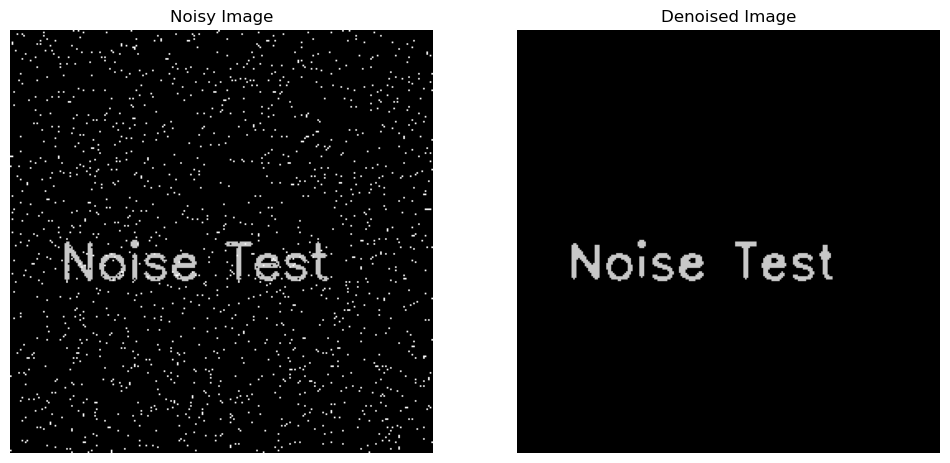

In [11]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib import pyplot as plt
import time

# --- Noise & PCA Denoising Functions ---

def add_salt_pepper_noise(img, amount=0.02, salt_vs_pepper=0.5):
    out = img.copy()
    h, w = img.shape[:2]
    num_salt = int(amount * h * w * salt_vs_pepper)
    num_pepper = int(amount * h * w * (1 - salt_vs_pepper))
    # Salt
    coords = (np.random.randint(0, h, num_salt), np.random.randint(0, w, num_salt))
    if img.ndim == 2:
        out[coords] = 255
    else:
        out[coords[0], coords[1], :] = 255
    # Pepper
    coords = (np.random.randint(0, h, num_pepper), np.random.randint(0, w, num_pepper))
    if img.ndim == 2:
        out[coords] = 0
    else:
        out[coords[0], coords[1], :] = 0
    return out


def _process_tile_median(prev_img, tile_rect, kernel_size):
    y0, y1, x0, x1 = tile_rect
    pad = kernel_size // 2
    H, W = prev_img.shape[:2]
    py0 = max(0, y0 - pad)
    py1 = min(H, y1 + pad)
    px0 = max(0, x0 - pad)
    px1 = min(W, x1 + pad)
    crop = prev_img[py0:py1, px0:px1]
    blurred = cv2.medianBlur(crop, kernel_size)
    cy0 = y0 - py0
    cy1 = cy0 + (y1 - y0)
    cx0 = x0 - px0
    cx1 = cx0 + (x1 - x0)
    return (tile_rect, blurred[cy0:cy1, cx0:cx1])


def pca_denoise(img, kernel_size=3, iterations=3, tile_size=128, num_workers=8):
    assert kernel_size % 2 == 1 and kernel_size >= 3, "kernel_size must be odd and >=3"
    h, w = img.shape[:2]
    current = img.copy()
    y_splits = list(range(0, h, tile_size))
    x_splits = list(range(0, w, tile_size))
    tile_rects = [(y0, min(h, y0 + tile_size), x0, min(w, x0 + tile_size)) for y0 in y_splits for x0 in x_splits]
    for it in range(iterations):
        prev = current
        next_img = np.empty_like(prev)
        with ThreadPoolExecutor(max_workers=num_workers) as ex:
            futures = [ex.submit(_process_tile_median, prev, rect, kernel_size) for rect in tile_rects]
            for f in as_completed(futures):
                rect, tile = f.result()
                y0, y1, x0, x1 = rect
                next_img[y0:y1, x0:x1] = tile
        current = next_img
    return current

# --- Create or load an image ---

img = cv2.imread("input.jpg")
if img is None:
    img = np.zeros((256, 256, 3), np.uint8)
    cv2.putText(img, "Noise Test", (30, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 200, 200), 2)

# --- Add noise and denoise ---

noisy = add_salt_pepper_noise(img, 0.05)
start = time.time()
denoised = pca_denoise(noisy, kernel_size=3, iterations=3, tile_size=128, num_workers=8)
end = time.time()
print(f"Denoising done in {end-start:.2f}s")

# --- Display results inline ---

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Noisy Image")
plt.imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Denoised Image")
plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
